In [1]:
import pandas as pd
import numpy as np

# sklearn for utilization
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, fbeta_score
from sklearn.model_selection import StratifiedKFold

# modelling for ensemble method
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# visualization purpose
import matplotlib.pyplot as plt

# utils
import pickle
import random

# import our ensemble stacking model here
#from deepstack.ensemble import StackEnsemble

from google.colab import files, drive
drive.mount('/content/gdrive', force_remount=True)

src = list(files.upload().values())[0]
open('model_ensembles.py','wb').write(src)
from model_ensembles import EnsembleStacking
#from params import Params

Mounted at /content/gdrive


Saving model_ensembles.py to model_ensembles.py


# Data Preparation



---

Load data Breast Cancer Diagnosis and Breast Cancer Prognosis after cleaned and preprocessed

In [37]:
from google.colab import drive
breast_cancer_preprocessed  = pickle.load(open('/content/gdrive/My Drive/ITS_S2/KK/preprocessed_breast_cancer_data.pkl', 'rb'))
#breast_cancer_preprocessed

# diagnosis breast cancer dataset
diagnosis_X_train_original = breast_cancer_preprocessed['diagnosis']['original']['X_train']
diagnosis_X_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['X_train']
diagnosis_X_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['X_train']

diagnosis_y_train_original = breast_cancer_preprocessed['diagnosis']['original']['y_train']
diagnosis_y_train_downsampling = breast_cancer_preprocessed['diagnosis']['downsampling']['y_train']
diagnosis_y_train_upsampling = breast_cancer_preprocessed['diagnosis']['upsampling']['y_train']

diagnosis_X_test_original = breast_cancer_preprocessed['diagnosis']['original']['X_test']
diagnosis_y_test_original = breast_cancer_preprocessed['diagnosis']['original']['y_test']



# prognosis breast cancer dataset
prognosis_X_train_original = breast_cancer_preprocessed['prognosis']['original']['X_train']
prognosis_X_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['X_train']
prognosis_X_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['X_train']

prognosis_y_train_original = breast_cancer_preprocessed['prognosis']['original']['y_train']
prognosis_y_train_downsampling = breast_cancer_preprocessed['prognosis']['downsampling']['y_train']
prognosis_y_train_upsampling = breast_cancer_preprocessed['prognosis']['upsampling']['y_train']

prognosis_X_test_original = breast_cancer_preprocessed['prognosis']['original']['X_test']
prognosis_y_test_original = breast_cancer_preprocessed['prognosis']['original']['y_test']

# Defining Global Variables

In [36]:
kfold = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)

# global variables for MLP
hidden_layer_sizes=(100,20)
max_iter=100
batch_size=64 
verbose=1
n_iter_no_change=20

# Defining Global Functions

In [4]:
def create_new_input_features(ensemble_classifiers, X, y):
    all_predicted_results = dict()
    list_of_majority_voting_each_models = list()
    list_of_models = list()

    for model_name, models in ensemble_classifiers.items():
        print("\t\t\t", model_name.upper())

        # voting scenario for new data input prepration for ANN model
        if len(models)!=0:
            all_predicted_results[model_name] = dict()
            for sub_model_name, dict_models in models.items():
                all_predicted_results[model_name][sub_model_name] = dict_models['train'].predict(X)

            # make dataframe for 5 model prediction results on X and get the mode label for that 5 prediction
            model_df_voting = pd.DataFrame(all_predicted_results[model_name]).mode(axis=1)[0]
            list_of_models.append('majority_vote_from_'+model_name)
            list_of_majority_voting_each_models.append(model_df_voting)
            
    new_input_features = pd.concat(list_of_majority_voting_each_models, axis=1)
    new_input_features.columns = list_of_models
    new_input_features['ground_truth'] = y.copy()
            
    return new_input_features

In [5]:
def print_model_experiment_results(name_of_scenario, y_test, y_pred):
    print('\t\t' + '='*30)
    print('\t\tHASIl UJI COBA {}'.format(name_of_scenario.upper()))
    print('\t\t' + '='*30)
    print("\tAkurasi Score: ", accuracy_score(y_test, y_pred))
    print("\tMacro Recall Score: ", recall_score(y_test, y_pred, average='macro'))
    print("\tMacro Precision Score: ", precision_score(y_test, y_pred, average='macro'))
    print("\tMacro F1-score Score: ", fbeta_score(y_test, y_pred, beta=1, average='macro'))
    print("\tMacro F2-score Score: ", fbeta_score(y_test, y_pred, beta=2, average='macro'))
    print("\tMacro F0.5-score Score: ", fbeta_score(y_test, y_pred, beta=0.5, average='macro'))
    
    print()
    print()
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(14,8))
    disp.plot()
    plt.show()

# Hyperparameter Optimization Techniques Using Grid Search

---

Find the best optimal hyperparameter from each model (SVM, DT, LR and also hyperparameter in ANN) and then build your model using the those best hyperparameter combination.

# **EKSPERIMEN 3**

# **Diagnosis Breast Cancer (Upsampling Dataset)**

# SVM

In [6]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from numpy import sort
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import recall_score, precision_score, fbeta_score
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator_upsampling = SVC(gamma='scale')
cv = StratifiedKFold(n_splits=5, random_state=45, shuffle=True)
svm_result_upsampling = HalvingGridSearchCV(svm_estimator_upsampling, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_upsampling, diagnosis_y_train_upsampling)
y_pred_svm_upsampling = svm_result_upsampling.predict(diagnosis_X_test_original)

In [7]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result_upsampling.best_score_, svm_result_upsampling.best_params_))
means = svm_result_upsampling.cv_results_['mean_test_score']
stds = svm_result_upsampling.cv_results_['std_test_score']
params = svm_result_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.964093 using Best Hyperparameters: {'C': 10, 'kernel': 'rbf'}
0.933333 (0.081650) with: {'C': 50, 'kernel': 'linear'}
0.966667 (0.066667) with: {'C': 50, 'kernel': 'poly'}
1.000000 (0.000000) with: {'C': 50, 'kernel': 'rbf'}
0.123810 (0.110040) with: {'C': 50, 'kernel': 'sigmoid'}
0.933333 (0.081650) with: {'C': 10, 'kernel': 'linear'}
0.966667 (0.066667) with: {'C': 10, 'kernel': 'poly'}
0.966667 (0.066667) with: {'C': 10, 'kernel': 'rbf'}
0.123810 (0.110040) with: {'C': 10, 'kernel': 'sigmoid'}
0.933333 (0.081650) with: {'C': 1.0, 'kernel': 'linear'}
0.933333 (0.081650) with: {'C': 1.0, 'kernel': 'poly'}
0.933333 (0.081650) with: {'C': 1.0, 'kernel': 'rbf'}
0.319048 (0.374832) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.819048 (0.208982) with: {'C': 0.1, 'kernel': 'linear'}
0.933333 (0.081650) with: {'C': 0.1, 'kernel': 'poly'}
0.823810 (0.209524) with: {'C': 0.1, 'kernel': 'rbf'}
0.404762 (0.339401) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.738095 (0.259949) with: {'C': 0.01

		HASIl UJI COBA SVM
	Akurasi Score:  0.9649122807017544
	Macro Recall Score:  0.9626596790042581
	Macro Precision Score:  0.9626596790042581
	Macro F1-score Score:  0.9626596790042581
	Macro F2-score Score:  0.9626596790042581
	Macro F0.5-score Score:  0.9626596790042581


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        71
           1       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



<Figure size 1008x576 with 0 Axes>

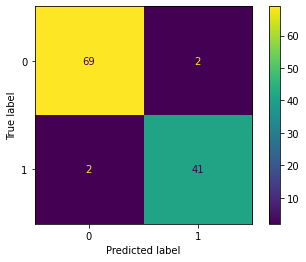

In [8]:
print_model_experiment_results("SVM", diagnosis_y_test_original, y_pred_svm_upsampling)

# Logistic Regression


In [11]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator_upsampling = LogisticRegression()
cv = kfold
lr_result_upsampling = HalvingGridSearchCV(base_estimator_upsampling, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_upsampling, diagnosis_y_train_upsampling)
y_pred_lr_upsampling = lr_result_upsampling.predict(diagnosis_X_test_original)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is no

In [12]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result_upsampling.best_score_, lr_result_upsampling.best_params_))
means = lr_result_upsampling.cv_results_['mean_test_score']
stds = lr_result_upsampling.cv_results_['std_test_score']
params = lr_result_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.955804 using Best Hyperparameters: {'C': 0.01, 'penalty': 'none', 'solver': 'sag'}
0.816667 (0.152753) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.816667 (0.152753) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.883333 (0.145297) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.883333 (0.145297) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.816667 (0.152753) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.883333 (0.145297) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.883333 (0.145297) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.883333 (0.145297) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.883333 (0.145

		HASIl UJI COBA LOGISTIC REGRESSION
	Akurasi Score:  0.9824561403508771
	Macro Recall Score:  0.9859154929577465
	Macro Precision Score:  0.9777777777777779
	Macro F1-score Score:  0.9814935064935065
	Macro F2-score Score:  0.9840602603099176
	Macro F0.5-score Score:  0.9791809358886547


              precision    recall  f1-score   support

           0       1.00      0.97      0.99        71
           1       0.96      1.00      0.98        43

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114



<Figure size 1008x576 with 0 Axes>

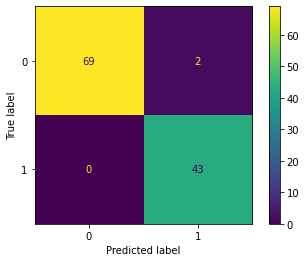

In [13]:
print_model_experiment_results("Logistic Regression", diagnosis_y_test_original, y_pred_lr_upsampling)

# Naive Bayes

In [14]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator_upsampling = MultinomialNB()
cv = kfold
nb_result_upsampling = HalvingGridSearchCV(base_estimator_upsampling, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_upsampling, diagnosis_y_train_upsampling)
y_pred_nb_upsampling = nb_result_upsampling.predict(diagnosis_X_test_original)

In [15]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result_upsampling.best_score_, nb_result_upsampling.best_params_))
means = nb_result_upsampling.cv_results_['mean_test_score']
stds = nb_result_upsampling.cv_results_['std_test_score']
params = nb_result_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.816828 using Best Hyperparameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': False}
0.438095 (0.061353) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.500000 (0.045175) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.466667 (0.080531) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.466667 (0.080531) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.466667 (0.080531) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.466667 (0.080531) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.523810 (0.177537) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.533333 (0.080531) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.466667 (0.080531) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.466667 (0.080531) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.466667 (0.080531) with: {'alpha': 10, 'class_prior':

		HASIl UJI COBA NAIVE BAYES
	Akurasi Score:  0.8771929824561403
	Macro Recall Score:  0.8555519161480512
	Macro Precision Score:  0.881010881010881
	Macro F1-score Score:  0.8652027027027027
	Macro F2-score Score:  0.8587257617728532
	Macro F0.5-score Score:  0.8738896793711752


              precision    recall  f1-score   support

           0       0.87      0.94      0.91        71
           1       0.89      0.77      0.82        43

    accuracy                           0.88       114
   macro avg       0.88      0.86      0.87       114
weighted avg       0.88      0.88      0.88       114



<Figure size 1008x576 with 0 Axes>

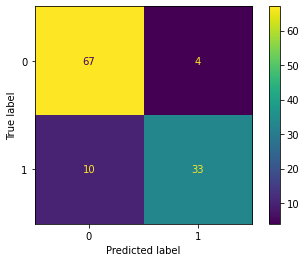

In [16]:
print_model_experiment_results("Naive Bayes", diagnosis_y_test_original, y_pred_nb_upsampling)

# Desicion Tree

In [20]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator_upsampling = DecisionTreeClassifier()
cv = kfold
dt_result_upsampling = HalvingGridSearchCV(base_estimator_upsampling, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_upsampling, diagnosis_y_train_upsampling)
y_pred_dt_upsampling = dt_result_upsampling.predict(diagnosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFailedW

In [21]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result_upsampling.best_score_, dt_result_upsampling.best_params_))
means = dt_result_upsampling.cv_results_['mean_test_score']
stds = dt_result_upsampling.cv_results_['std_test_score']
params = dt_result_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.940718 using Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'gini', 'splitter': 'best'}
0.528571 (0.034993) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.528571 (0.034993) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.528571 (0.034993) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.528571 (0.034993) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.528571 (0.034993) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.528571 (0.034993) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.528571 (0.034993) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.528571 (0.034993) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (

		HASIl UJI COBA DECISION TREE
	Akurasi Score:  0.9473684210526315
	Macro Recall Score:  0.9439895185063871
	Macro Precision Score:  0.9439895185063871
	Macro F1-score Score:  0.9439895185063871
	Macro F2-score Score:  0.9439895185063871
	Macro F0.5-score Score:  0.9439895185063871


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



<Figure size 1008x576 with 0 Axes>

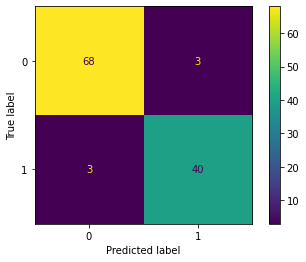

In [22]:
print_model_experiment_results("Decision Tree", diagnosis_y_test_original, y_pred_dt_upsampling)

# ANN

In [24]:
param_grid = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }
# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_diagnosis_upsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(diagnosis_X_train_upsampling, diagnosis_y_train_upsampling)
y_pred_ann_diagnosis_upsampling = ann_result_diagnosis_upsampling.predict(diagnosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [25]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_diagnosis_upsampling.best_score_, ann_result_diagnosis_upsampling.best_params_))
means = ann_result_diagnosis_upsampling.cv_results_['mean_test_score']
stds = ann_result_diagnosis_upsampling.cv_results_['std_test_score']
params = ann_result_diagnosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.971627 using Best Hyperparameters: {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 40, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.900000 (0.200000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.850000 (0.200000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.900000 (0.200000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.900000 (0.200000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.533333 (0.124722) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.850000 (0.200000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.900000 (0.200000) with: {'activation': 'i

		HASIl UJI COBA ANN
	Akurasi Score:  0.9298245614035088
	Macro Recall Score:  0.9253193580085162
	Macro Precision Score:  0.9253193580085162
	Macro F1-score Score:  0.9253193580085162
	Macro F2-score Score:  0.9253193580085162
	Macro F0.5-score Score:  0.9253193580085162


              precision    recall  f1-score   support

           0       0.94      0.94      0.94        71
           1       0.91      0.91      0.91        43

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



<Figure size 1008x576 with 0 Axes>

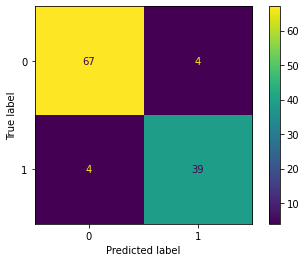

In [26]:
print_model_experiment_results("ANN", diagnosis_y_test_original, y_pred_ann_diagnosis_upsampling)

# Create Stacking ML Ensemble

In [32]:
gridsearchcv__ensemble_classifiers_diagnosis_upsampling = EnsembleStacking(
    diagnosis_X_train_upsampling,
    diagnosis_y_train_upsampling,
    diagnosis_X_test_original,
    diagnosis_y_test_original,
    kfold
).train_ensemble()

In [33]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results = list()
for model in gridsearchcv__ensemble_classifiers_diagnosis_upsampling.keys():
    ensemble_classifiers_results.append(pd.DataFrame(gridsearchcv__ensemble_classifiers_diagnosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results = pd.concat(ensemble_classifiers_results, axis=0)

In [34]:
ensemble_classifiers_results

,train,training,validation,testing
model-1,SVC(),0.958425,0.930435,0.973684
model-3,SVC(),0.943231,0.938596,0.964912
model-5,SVC(),0.958515,0.912281,0.964912
model-2,SVC(),0.95186,0.965217,0.95614
model-4,SVC(),0.949782,0.964912,0.947368
model-1,LogisticRegression(solver='newton-cg'),0.932166,0.947826,0.964912
model-2,LogisticRegression(solver='newton-cg'),0.934354,0.930435,0.95614
model-3,LogisticRegression(solver='newton-cg'),0.936681,0.929825,0.95614
model-4,LogisticRegression(solver='newton-cg'),0.934498,0.947368,0.95614
model-5,LogisticRegression(solver='newton-cg'),0.941048,0.912281,0.95614


# Create new input Training from the stacking ensemble ML

In [38]:
gridsearchcv_algorithm_new_input_training_features_diagnosis_upsampling = create_new_input_features(
    gridsearchcv__ensemble_classifiers_diagnosis_upsampling, 
    diagnosis_X_train_original,
    diagnosis_y_train_original
)


			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [41]:
gridsearchcv_algorithm_new_input_training_features_diagnosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,0,1,0,0
1,1,1,1,1,1
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


# Feed New Input Features into ANN Model

In [42]:
# split X and y from new_input_features before feeding to ANN
new_X_train = gridsearchcv_algorithm_new_input_training_features_diagnosis_upsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = gridsearchcv_algorithm_new_input_training_features_diagnosis_upsampling[
    'ground_truth']
ann_params = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }

# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_diagnosis_upsampling = HalvingGridSearchCV(base_estimator, ann_params, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(new_X_train, new_y_train)
y_pred_ann_diagnosis_upsampling = ann_result_diagnosis_upsampling.predict(new_X_train)



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [43]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_diagnosis_upsampling.best_score_, ann_result_diagnosis_upsampling.best_params_))
means = ann_result_diagnosis_upsampling.cv_results_['mean_test_score']
stds = ann_result_diagnosis_upsampling.cv_results_['std_test_score']
params = ann_result_diagnosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.996875 using Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 80, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.900000 (0.122474) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.900000 (0.122474) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.700000 (0.367423) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.900000 (0.122474) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.950000 (0.100000) with: {'activation': 'identit

		HASIl UJI COBA ANN
	Akurasi Score:  0.9956043956043956
	Macro Recall Score:  0.9940828402366864
	Macro Precision Score:  0.9965277777777778
	Macro F1-score Score:  0.995281649245064
	Macro F2-score Score:  0.9945567174960404
	Macro F0.5-score Score:  0.9960236157014838


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       286
           1       1.00      0.99      0.99       169

    accuracy                           1.00       455
   macro avg       1.00      0.99      1.00       455
weighted avg       1.00      1.00      1.00       455



<Figure size 1008x576 with 0 Axes>

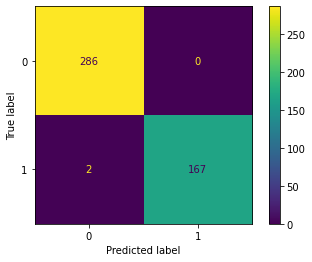

In [44]:
print_model_experiment_results("ANN", new_y_train, y_pred_ann_diagnosis_upsampling)

# **Prognosis breast cancer (Upsampling Dataset)**

#SVM

In [45]:
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
               'C': [50, 10, 1.0, 0.1, 0.01]}
svm_estimator = SVC(gamma='scale')
cv = kfold
svm_result_prognosis_upsampling = HalvingGridSearchCV(svm_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_upsampling, prognosis_y_train_upsampling)
y_pred_svm_prognosis_upsampling = svm_result_prognosis_upsampling.predict(prognosis_X_test_original)

In [46]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (svm_result_prognosis_upsampling.best_score_, svm_result_prognosis_upsampling.best_params_))
means = svm_result_prognosis_upsampling.cv_results_['mean_test_score']
stds = svm_result_prognosis_upsampling.cv_results_['std_test_score']
params = svm_result_prognosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.835685 using Best Hyperparameters: {'C': 50, 'kernel': 'rbf'}
0.583333 (0.333333) with: {'C': 50, 'kernel': 'linear'}
0.600000 (0.161589) with: {'C': 50, 'kernel': 'poly'}
0.666667 (0.229734) with: {'C': 50, 'kernel': 'rbf'}
0.666667 (0.091287) with: {'C': 50, 'kernel': 'sigmoid'}
0.583333 (0.333333) with: {'C': 10, 'kernel': 'linear'}
0.600000 (0.161589) with: {'C': 10, 'kernel': 'poly'}
0.666667 (0.229734) with: {'C': 10, 'kernel': 'rbf'}
0.583333 (0.247207) with: {'C': 10, 'kernel': 'sigmoid'}
0.550000 (0.266667) with: {'C': 1.0, 'kernel': 'linear'}
0.500000 (0.190029) with: {'C': 1.0, 'kernel': 'poly'}
0.683333 (0.185592) with: {'C': 1.0, 'kernel': 'rbf'}
0.633333 (0.250555) with: {'C': 1.0, 'kernel': 'sigmoid'}
0.633333 (0.250555) with: {'C': 0.1, 'kernel': 'linear'}
0.666667 (0.278887) with: {'C': 0.1, 'kernel': 'poly'}
0.633333 (0.250555) with: {'C': 0.1, 'kernel': 'rbf'}
0.633333 (0.250555) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.633333 (0.250555) with: {'C': 0.01

		HASIl UJI COBA SVM
	Akurasi Score:  0.8461538461538461
	Macro Recall Score:  0.8100649350649352
	Macro Precision Score:  0.8100649350649352
	Macro F1-score Score:  0.8100649350649352
	Macro F2-score Score:  0.8100649350649352
	Macro F0.5-score Score:  0.8100649350649352


              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.73      0.73      0.73        11

    accuracy                           0.85        39
   macro avg       0.81      0.81      0.81        39
weighted avg       0.85      0.85      0.85        39



<Figure size 1008x576 with 0 Axes>

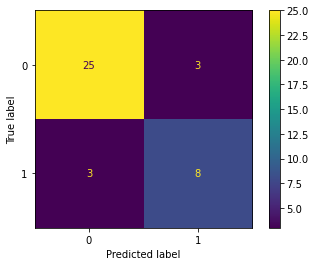

In [47]:
print_model_experiment_results("SVM", prognosis_y_test_original, y_pred_svm_prognosis_upsampling)

# Logistic Regression

In [48]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, RepeatedStratifiedKFold
param_grid = {'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
              'penalty': ['none', 'l1', 'l2', 'elasticnet'],
               'C': [50, 10, 1.0, 0.1, 0.01]}
base_estimator = LogisticRegression()
cv = kfold
lr_result_prognosis_upsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_upsampling, prognosis_y_train_upsampling)
y_pred_lr_prognosis_upsampling = lr_result_prognosis_upsampling.predict(prognosis_X_test_original)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
225 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 464, in _check_solver
    raise ValueError("penalty='none' is no

In [49]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (lr_result_prognosis_upsampling.best_score_, lr_result_prognosis_upsampling.best_params_))
means = lr_result_prognosis_upsampling.cv_results_['mean_test_score']
stds = lr_result_prognosis_upsampling.cv_results_['std_test_score']
params = lr_result_prognosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.822782 using Best Hyperparameters: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.616667 (0.187083) with: {'C': 50, 'penalty': 'none', 'solver': 'newton-cg'}
0.550000 (0.214735) with: {'C': 50, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'none', 'solver': 'liblinear'}
0.550000 (0.214735) with: {'C': 50, 'penalty': 'none', 'solver': 'sag'}
0.616667 (0.281859) with: {'C': 50, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'lbfgs'}
0.733333 (0.161589) with: {'C': 50, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 50, 'penalty': 'l1', 'solver': 'sag'}
0.616667 (0.281859) with: {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
0.550000 (0.214735) with: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
0.550000 (0.214735) with: {'C': 50, 'penalty': 'l2', 'solver': 'lbfgs'}
0.550000 (0.2

		HASIl UJI COBA LOGISTIC REGRESSION
	Akurasi Score:  0.7692307692307693
	Macro Recall Score:  0.7840909090909092
	Macro Precision Score:  0.7377717391304348
	Macro F1-score Score:  0.7450980392156862
	Macro F2-score Score:  0.7638888888888888
	Macro F0.5-score Score:  0.7375


              precision    recall  f1-score   support

           0       0.91      0.75      0.82        28
           1       0.56      0.82      0.67        11

    accuracy                           0.77        39
   macro avg       0.74      0.78      0.75        39
weighted avg       0.81      0.77      0.78        39



<Figure size 1008x576 with 0 Axes>

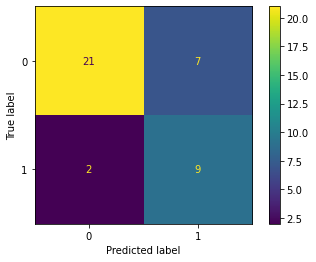

In [50]:
print_model_experiment_results("Logistic Regression", prognosis_y_test_original, y_pred_lr_prognosis_upsampling)

# Naive Bayes

In [51]:
param_grid = {"alpha": [50, 10, 1.0, 0.1, 0.01],
              "fit_prior": (True, False),
              'class_prior': [None, [.1,.9],[.2, .8]],
            }
base_estimator = MultinomialNB()
cv = kfold
nb_result_prognosis_upsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_upsampling, prognosis_y_train_upsampling)
y_pred_nb_prognosis_upsampling = nb_result_prognosis_upsampling.predict(prognosis_X_test_original)

In [52]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (nb_result_prognosis_upsampling.best_score_, nb_result_prognosis_upsampling.best_params_))
means = nb_result_prognosis_upsampling.cv_results_['mean_test_score']
stds = nb_result_prognosis_upsampling.cv_results_['std_test_score']
params = nb_result_prognosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.588911 using Best Hyperparameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': False}
0.516667 (0.219848) with: {'alpha': 50, 'class_prior': None, 'fit_prior': True}
0.783333 (0.194365) with: {'alpha': 50, 'class_prior': None, 'fit_prior': False}
0.716667 (0.040825) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.716667 (0.040825) with: {'alpha': 50, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.716667 (0.040825) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': True}
0.716667 (0.040825) with: {'alpha': 50, 'class_prior': [0.2, 0.8], 'fit_prior': False}
0.516667 (0.219848) with: {'alpha': 10, 'class_prior': None, 'fit_prior': True}
0.733333 (0.226078) with: {'alpha': 10, 'class_prior': None, 'fit_prior': False}
0.716667 (0.040825) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': True}
0.716667 (0.040825) with: {'alpha': 10, 'class_prior': [0.1, 0.9], 'fit_prior': False}
0.716667 (0.040825) with: {'alpha': 10, 'class_prior':

		HASIl UJI COBA NAIVE BAYES
	Akurasi Score:  0.6410256410256411
	Macro Recall Score:  0.7224025974025974
	Macro Precision Score:  0.686141304347826
	Macro F1-score Score:  0.6350267379679144
	Macro F2-score Score:  0.6661030783582089
	Macro F0.5-score Score:  0.6503271422541157


              precision    recall  f1-score   support

           0       0.94      0.54      0.68        28
           1       0.43      0.91      0.59        11

    accuracy                           0.64        39
   macro avg       0.69      0.72      0.64        39
weighted avg       0.80      0.64      0.66        39



<Figure size 1008x576 with 0 Axes>

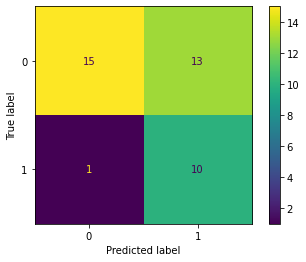

In [53]:
print_model_experiment_results("Naive Bayes", prognosis_y_test_original, y_pred_nb_prognosis_upsampling)

# Decision Tree

In [54]:
param_grid = {'criterion': ('gini', 'entropy', 'log_loss'),
               'ccp_alpha': [50, 10, 1.0, 0.1, 0.01],
              'splitter': ('best', 'random')
              }
base_estimator = DecisionTreeClassifier()
cv = kfold
dt_result_prognosis_upsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_upsampling, prognosis_y_train_upsampling)
y_pred_dt_prognosis_upsampling = dt_result_prognosis_upsampling.predict(prognosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_message, FitFailedW

In [55]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (dt_result_prognosis_upsampling.best_score_, dt_result_prognosis_upsampling.best_params_))
means = dt_result_prognosis_upsampling.cv_results_['mean_test_score']
stds = dt_result_prognosis_upsampling.cv_results_['std_test_score']
params = dt_result_prognosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.847581 using Best Hyperparameters: {'ccp_alpha': 0.01, 'criterion': 'entropy', 'splitter': 'best'}
0.566667 (0.275882) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'best'}
0.566667 (0.275882) with: {'ccp_alpha': 50, 'criterion': 'gini', 'splitter': 'random'}
0.566667 (0.275882) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'best'}
0.566667 (0.275882) with: {'ccp_alpha': 50, 'criterion': 'entropy', 'splitter': 'random'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'best'}
0.000000 (0.000000) with: {'ccp_alpha': 50, 'criterion': 'log_loss', 'splitter': 'random'}
0.566667 (0.275882) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'best'}
0.566667 (0.275882) with: {'ccp_alpha': 10, 'criterion': 'gini', 'splitter': 'random'}
0.566667 (0.275882) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'best'}
0.566667 (0.275882) with: {'ccp_alpha': 10, 'criterion': 'entropy', 'splitter': 'random'}
0.00000

		HASIl UJI COBA DECISION TREE
	Akurasi Score:  0.717948717948718
	Macro Recall Score:  0.6655844155844155
	Macro Precision Score:  0.6574074074074074
	Macro F1-score Score:  0.6608695652173913
	Macro F2-score Score:  0.6635405960945528
	Macro F0.5-score Score:  0.6586490528414755


              precision    recall  f1-score   support

           0       0.81      0.79      0.80        28
           1       0.50      0.55      0.52        11

    accuracy                           0.72        39
   macro avg       0.66      0.67      0.66        39
weighted avg       0.73      0.72      0.72        39



<Figure size 1008x576 with 0 Axes>

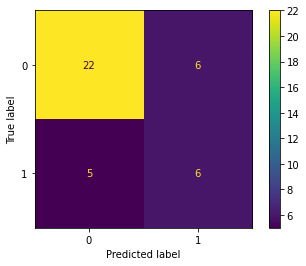

In [56]:
print_model_experiment_results("Decision Tree", prognosis_y_test_original, y_pred_dt_prognosis_upsampling)

# ANN

In [57]:
param_grid = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }
# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_prognosis_upsampling = HalvingGridSearchCV(base_estimator, param_grid, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(prognosis_X_train_upsampling, prognosis_y_train_upsampling)
y_pred_ann_prognosis_upsampling = ann_result_prognosis_upsampling.predict(prognosis_X_test_original)


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [58]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_prognosis_upsampling.best_score_, ann_result_prognosis_upsampling.best_params_))
means = ann_result_prognosis_upsampling.cv_results_['mean_test_score']
stds = ann_result_prognosis_upsampling.cv_results_['std_test_score']
params = ann_result_prognosis_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.836290 using Best Hyperparameters: {'activation': 'relu', 'alpha': 0.1, 'batch_size': 80, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.750000 (0.223607) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.633333 (0.250555) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
0.683333 (0.185592) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
0.750000 (0.223607) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.500000 (0.353553) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
0.683333 (0.185592) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
0.750000 (0.223607) with: {'activation': 'identit

		HASIl UJI COBA ANN
	Akurasi Score:  0.8461538461538461
	Macro Recall Score:  0.8652597402597402
	Macro Precision Score:  0.8125
	Macro F1-score Score:  0.8269230769230769
	Macro F2-score Score:  0.8465229312063807
	Macro F0.5-score Score:  0.8158223534756929


              precision    recall  f1-score   support

           0       0.96      0.82      0.88        28
           1       0.67      0.91      0.77        11

    accuracy                           0.85        39
   macro avg       0.81      0.87      0.83        39
weighted avg       0.88      0.85      0.85        39



<Figure size 1008x576 with 0 Axes>

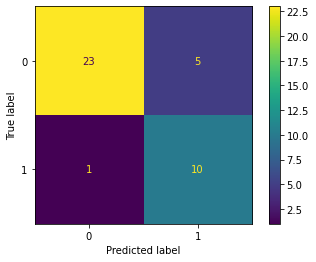

In [59]:
print_model_experiment_results("ANN", prognosis_y_test_original, y_pred_ann_prognosis_upsampling)

# Create Stacking ML Ensemble

In [60]:
gridsearchcv__ensemble_classifiers_prognosis_upsampling = EnsembleStacking(
    prognosis_X_train_upsampling,
    prognosis_y_train_upsampling,
    prognosis_X_test_original,
    prognosis_y_test_original,
    kfold
).train_ensemble()

In [61]:
# create dataframe for easy understanding from ensemble classifiers stacking results
ensemble_classifiers_results = list()
for model in gridsearchcv__ensemble_classifiers_prognosis_upsampling.keys():
    ensemble_classifiers_results.append(pd.DataFrame(gridsearchcv__ensemble_classifiers_prognosis_upsampling[model]).transpose().sort_values(by=['testing'], ascending=False))

# concat all dataframe results
ensemble_classifiers_results = pd.concat(ensemble_classifiers_results, axis=0)

In [62]:
ensemble_classifiers_results

,train,training,validation,testing
model-1,SVC(),0.921053,0.75,0.74359
model-3,SVC(),0.894737,0.875,0.74359
model-2,SVC(),0.894737,0.791667,0.717949
model-5,SVC(),0.895288,0.829787,0.717949
model-4,SVC(),0.890052,0.808511,0.666667
model-2,LogisticRegression(solver='newton-cg'),0.721053,0.75,0.74359
model-5,LogisticRegression(solver='newton-cg'),0.748691,0.659574,0.74359
model-1,LogisticRegression(solver='newton-cg'),0.736842,0.604167,0.666667
model-3,LogisticRegression(solver='newton-cg'),0.705263,0.8125,0.666667
model-4,LogisticRegression(solver='newton-cg'),0.722513,0.680851,0.666667


# Create new input Training from the stacking ensemble ML

In [63]:
gridsearchcv_algorithm_new_input_training_features_prognosis_upsampling = create_new_input_features(
    gridsearchcv__ensemble_classifiers_prognosis_upsampling, 
    prognosis_X_train_original,
    prognosis_y_train_original
)


			 SVM
			 LOGREG
			 NAIVE_BAYES
			 DECISION_TREE


In [64]:
gridsearchcv_algorithm_new_input_training_features_prognosis_upsampling.head()

,majority_vote_from_svm,majority_vote_from_logreg,majority_vote_from_naive_bayes,majority_vote_from_decision_tree,ground_truth
0,0,1,1,0,0
1,1,1,1,1,1
2,1,1,1,0,0
3,1,1,1,1,1
4,0,0,1,0,0


# Feed New Input Features into ANN Model

In [65]:
# split X and y from new_input_features before feeding to ANN
new_X_train = gridsearchcv_algorithm_new_input_training_features_prognosis_upsampling.drop([
                                                                                    'ground_truth'], axis=1)
new_y_train = gridsearchcv_algorithm_new_input_training_features_prognosis_upsampling[
    'ground_truth']
ann_params = {
              'batch_size': [10, 20, 40, 60, 80, 100],
              #'epochs': [10, 50, 100],
              'activation': ('identity', 'softmax', 'logistic', 'tanh', 'relu'),
              'solver':('lbfgs', 'sgd', 'adam'),
              'learning_rate': ('constant', 'invscaling', 'adaptive'),
              'alpha': [0.1, 0.01, 0.0001],
              }

# create model
base_estimator = MLPClassifier()
cv = kfold
ann_result_prognois_upsampling = HalvingGridSearchCV(base_estimator, ann_params, cv=cv, n_jobs=-1, scoring='accuracy',error_score=0,
                        factor=2, min_resources='exhaust',
                         aggressive_elimination=False).fit(new_X_train, new_y_train)
y_pred_ann_prognois_upsampling = ann_result_prognois_upsampling.predict(new_X_train)



/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
810 fits failed out of a total of 4050.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 752, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 440, in _fit
    self._fit_lbfgs(
  File "/usr/local

In [66]:
# summarize results
print("Best Score: %f using Best Hyperparameters: %s" % (ann_result_prognois_upsampling.best_score_, ann_result_prognois_upsampling.best_params_))
means = ann_result_prognois_upsampling.cv_results_['mean_test_score']
stds = ann_result_prognois_upsampling.cv_results_['std_test_score']
params = ann_result_prognois_upsampling.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best Score: 0.987500 using Best Hyperparameters: {'activation': 'identity', 'alpha': 0.01, 'batch_size': 100, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
1.000000 (0.000000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'lbfgs'}
0.950000 (0.100000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'sgd'}
1.000000 (0.000000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'constant', 'solver': 'adam'}
1.000000 (0.000000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
0.800000 (0.291548) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'sgd'}
1.000000 (0.000000) with: {'activation': 'identity', 'alpha': 0.1, 'batch_size': 10, 'learning_rate': 'invscaling', 'solver': 'adam'}
1.000000 (0.000000) with: {'activation': '

		HASIl UJI COBA ANN
	Akurasi Score:  0.9935064935064936
	Macro Recall Score:  0.9857142857142858
	Macro Precision Score:  0.9958333333333333
	Macro F1-score Score:  0.9906615729792008
	Macro F2-score Score:  0.9876668209519401
	Macro F0.5-score Score:  0.9937371252282068


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       119
           1       1.00      0.97      0.99        35

    accuracy                           0.99       154
   macro avg       1.00      0.99      0.99       154
weighted avg       0.99      0.99      0.99       154



<Figure size 1008x576 with 0 Axes>

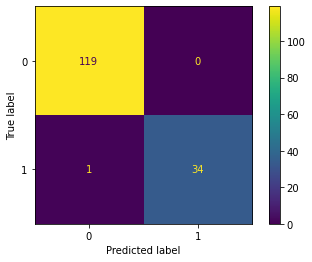

In [67]:
print_model_experiment_results("ANN", new_y_train, y_pred_ann_prognois_upsampling)